Two input files: 

- CDR BED files 

- Centromere annotation files 


We want to get stats on CDRs which is where the centromere annotation track overlaps with the strict CDR bed files

(1) start and end of the total CDR in the array 

(2) the size and spacing of the internal components, or collection of CDRs 


In [2]:
import os
import seaborn as sns
import matplotlib as plt
import pandas as pd
import numpy as np
from natsort import index_natsorted, order_by_index
sns.set()  # Don't forget this!
from matplotlib import pyplot

%matplotlib inline

In [35]:
class CDR:
    def __init__(self, numChr, hap, start, end) -> None:
        '''
        Class for each unique overlap (centromere dip region) for each chromosome
        '''
        self.numChr = numChr
        self.hap = hap
        self.start = int(start)  # convert to int, otherwise returns Nonetype error
        self.end = int(end)

In [28]:
# parsing the overlapping regions bedfiles
def bedParse(dir):
    """
    bedParse takes in a file folder of bedfiles outputted from bedtools intersect
    and stores all the information into a list of CDR objects.
    Returns a list of CDR objects. 
    """
    # store all unique overlaps as individual CDR objects
    cdr_list = []
    for root, dirs, files in os.walk(dir): # open folder intersectOutputs
        for filename in files:  # iterate through each file in the folder
            filepath = os.path.join(root, filename)  # file path
            filename_split = filename.split('_')
            if filename != '.DS_Store' and filename[6:10] != 'acro' and filename_split[1][:4] != 'chrM' and filename_split[1][:6] != 'chrEBV':  # dont read in the .DS_store file
                with open(filepath) as f:  # now we are in the file
                    lines = f.readlines()
                    uniques = set()
                    allCDRs = []
                    for line in lines: # for each line of overlaps in the file
                        col = line.split()
                        start, end = col[1], col[2]  # 2nd, 3rd column
                        uniques.add((start,end))
                        allCDRs.append((start, end))
                    # filename_split = filename.split('_')
                    # for tup in uniques:
                    for tup in allCDRs:
                        if filename_split[0][2:].isalpha():  # if the chromosome is X or Y (after chr)
                            cdr = CDR(filename_split[0][2:], filename_split[1], tup[0], tup[1])
                        else:  # if the chromosome is a number then store the chromosome num as an int
                            cdr = CDR(int(filename_split[0][2:]), filename_split[1], tup[0], tup[1])
                        cdr_list.append(cdr)
    return cdr_list

directory = '/Users/emilyxu/Desktop/cdrproject/intersectOutputs'
cdr_list = bedParse(directory)

directory = '/Users/emilyxu/Desktop/cdrproject/CDRStrictBedFiles'

strictBed = []
for root, dirs, files in os.walk(directory): # open folder intersectOutputs
    for filename in files:  # iterate through each file in the folder
        filepath = os.path.join(root, filename)  # file path
        filename_split = filename.split('_')
        if filename != '.DS_Store' and filename[6:10] != 'acro' and filename_split[1][:4] != 'chrM' and filename_split[1][:6] != 'chrEBV':  # dont read in certain files
            with open(filepath) as f:  # now we are in the file
                strictBed.append((filename_split[1][3:], filename_split[2][:8], len(f.readlines())))
strictBedDF = pd.DataFrame(strictBed, columns=['ChrmNum','haplotype', 'length'])
strictBedDF = strictBedDF.reindex(index=order_by_index(strictBedDF.index, index_natsorted(strictBedDF['ChrmNum'], reverse=False)))


In [36]:
# For Justin's HMM bedfiles

def bedParse(dir):
    """
    bedParse takes in a file folder of bedfiles outputted from bedtools intersect
    and stores all the information into a list of CDR objects.
    Returns a list of CDR objects. 
    """
    # store all unique overlaps as individual CDR objects
    cdr_list = []
    for root, dirs, files in os.walk(dir): # open folder intersectOutputs
        for filename in files:  # iterate through each file in the folder
            filepath = os.path.join(root, filename)  # file path
            filename_split = filename.split('_')
            if filename != '.DS_Store' and filename[6:10] != 'acro' and filename_split[1][:4] != 'chrM' and filename_split[1][:6] != 'chrEBV':  # dont read in the .DS_store file
                with open(filepath) as f:  # now we are in the file
                    lines = f.readlines()
                    uniques = set()
                    allCDRs = []
                    for line in lines: # for each line of overlaps in the file
                        col = line.split()
                        start, end = col[1], col[2]  # 2nd, 3rd column
                        uniques.add((start,end))
                        allCDRs.append((start, end))
                    # filename_split = filename.split('_')
                    # for tup in uniques:
                    for tup in allCDRs:
                        # print(filename_split[1][3:], filename_split[2][:8])
                        if filename_split[1][3:].isalpha():  # if the chromosome is X or Y (after chr)
                            cdr = CDR(filename_split[1][3:], filename_split[2][:8], tup[0], tup[1])
                        else:  # if the chromosome is a number then store the chromosome num as an int
                            cdr = CDR(int(filename_split[1][3:]), filename_split[2][:8], tup[0], tup[1])
                        cdr_list.append(cdr)
    return cdr_list

directory = '/Users/emilyxu/Desktop/cdrproject/HMMBedData'
hmmList = bedParse(directory)


In [29]:
# strict bedfiles parsing
strictBed = []
for root, dirs, files in os.walk(directory): # open folder intersectOutputs
    for filename in files:  # iterate through each file in the folder
        filepath = os.path.join(root, filename)  # file path
        filename_split = filename.split('_')
        if filename != '.DS_Store' and filename[6:10] != 'acro' and filename_split[1][:4] != 'chrM' and filename_split[1][:6] != 'chrEBV':  # dont read in certain files
            with open(filepath) as f:  # now we are in the file
                strictBed.append((filename_split[1][3:], filename_split[2][:8], len(f.readlines())))
strictBedDF = pd.DataFrame(strictBed, columns=['ChrmNum','haplotype', 'length'])
strictBedDF['haplotype'] = strictBedDF['haplotype'].str.lower()
strictBedDF = strictBedDF.reindex(index=order_by_index(strictBedDF.index, index_natsorted(strictBedDF['ChrmNum'], reverse=False)))


# Data Exploration

## Over all chromosomes

In [30]:
# 1. summary of lengths of CDRs across all chromosomes
#    boxplot or histogram 

# all CDR ranges in one dataframe
# chr#     start       end
# chr6   43824280    49285928
# chr6    3948239    3949240

allDF = pd.DataFrame([(cdr.numChr, (cdr.start, cdr.end), cdr.hap) for cdr in cdr_list], 
                    columns=['ChrmNum','ranges', 'haplotype'])

# sort df by chromosome number
allDF = allDF.reindex(index=order_by_index(allDF.index, index_natsorted(allDF['ChrmNum'], reverse=False)))
allDF['start'], allDF['end'] = allDF.ranges.str
allDF['length'] = allDF['end'] - allDF['start']
# display(df)  # display dataframe in a nice way
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # print entire dataframe out
#     print(df)

# sort uniques
uniques = allDF.groupby('ranges').first().reset_index()
uniques = uniques.reindex(index=order_by_index(uniques.index, index_natsorted(uniques['ChrmNum'], reverse=False)))
uniques = uniques[['ChrmNum', 'ranges', 'haplotype', 'start', 'end', 'length']]

print(allDF)


      ChrmNum                  ranges haplotype      start        end  length
5302        1  (124421626, 124444626)  paternal  124421626  124444626   23000
5303        1  (124421626, 124444626)  paternal  124421626  124444626   23000
5304        1  (124421626, 124444626)  paternal  124421626  124444626   23000
5305        1  (124421626, 124444626)  paternal  124421626  124444626   23000
5306        1  (124421626, 124444626)  paternal  124421626  124444626   23000
...       ...                     ...       ...        ...        ...     ...
29319       Y    (19142688, 19146688)  paternal   19142688   19146688    4000
29320       Y    (19142688, 19146688)  paternal   19142688   19146688    4000
29321       Y    (19142688, 19146688)  paternal   19142688   19146688    4000
29322       Y    (19142688, 19146688)  paternal   19142688   19146688    4000
29323       Y    (19142688, 19146688)  paternal   19142688   19146688    4000

[50318 rows x 6 columns]


/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


In [37]:
# Justin's HMM dataframe

allHMM = pd.DataFrame([(cdr.numChr, (cdr.start, cdr.end), cdr.hap) for cdr in hmmList], 
                    columns=['ChrmNum','ranges', 'haplotype'])

# sort df by chromosome number
allHMM = allHMM.reindex(index=order_by_index(allHMM.index, index_natsorted(allHMM['ChrmNum'], reverse=False)))
allHMM['start'], allHMM['end'] = allHMM.ranges.str
allHMM['length'] = allHMM['end'] - allHMM['start']
# display(df)  # display dataframe in a nice way
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # print entire dataframe out
#     print(df)

# sort uniques
uniqueHMM = allHMM.groupby('ranges').first().reset_index()
uniqueHMM = uniqueHMM.reindex(index=order_by_index(uniqueHMM.index, index_natsorted(uniqueHMM['ChrmNum'], reverse=False)))
uniqueHMM = uniqueHMM[['ChrmNum', 'ranges', 'haplotype', 'start', 'end', 'length']]

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # print entire dataframe out
#     print(allDF)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # print entire dataframe out
    print(uniqueHMM)

    ChrmNum                  ranges haplotype      start        end    length
623       1  (122588553, 122607144)  MATERNAL  122588553  122607144     18591
624       1  (122608264, 122609774)  MATERNAL  122608264  122609774      1510
625       1  (122610340, 122652509)  MATERNAL  122610340  122652509     42169
626       1  (122670602, 122671622)  MATERNAL  122670602  122671622      1020
627       1  (122674913, 122686663)  MATERNAL  122674913  122686663     11750
628       1  (122778974, 122788123)  MATERNAL  122778974  122788123      9149
629       1  (122830746, 122837895)  MATERNAL  122830746  122837895      7149
630       1  (124421467, 124444586)  PATERNAL  124421467  124444586     23119
631       1  (124450704, 124454293)  PATERNAL  124450704  124454293      3589
632       1  (124469842, 124488853)  PATERNAL  124469842  124488853     19011
633       1  (124500101, 124516236)  PATERNAL  124500101  124516236     16135
634       1  (124547681, 124565094)  PATERNAL  124547681  124565

/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


In [8]:
# statistical questions: 
# 1. How many times does each duplicate occur?
# Format:
#                                   numOcc
# Chr 1: (124421626, 124444626):     16

counts = allDF.groupby(allDF.columns.tolist(),as_index=False).size()
counts = counts.reindex(index=order_by_index(counts.index, index_natsorted(counts['size'], reverse=True)))
counts['overlap occurrences'] = counts['size']
# display(counts[['ChrmNum', 'ranges','haplotype','occurrences']])

# 2. What is the percentage of overlaps vs non overlaps? 
# --> compare strict bedfiles with intersect bedfiles (uniques)

total = counts.groupby(['ChrmNum', 'haplotype'])['overlap occurrences'].sum()
total = total.reset_index()
total['Chrm'] = total['ChrmNum'].astype(str) + '_' + total['haplotype']

strictBedDF = strictBedDF.reset_index(drop=True)
strictBedDF['Chrm'] = strictBedDF['ChrmNum'].astype(str) + '_' + strictBedDF['haplotype']

merged = strictBedDF.merge(total, how='outer', on='Chrm')
merged[['Chrm', 'length', 'overlap occurrences']]

merged['percent of overlaps'] = (merged['overlap occurrences'] / merged['length']) * 100
merged['percent of non-overlaps'] = ((merged['length'] - merged['overlap occurrences']) / merged['length']) * 100
display(merged)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # print entire dataframe out
#     print(merged)

,ChrmNum_x,haplotype_x,length,Chrm,ChrmNum_y,haplotype_y,overlap occurrences,percent of overlaps,percent of non-overlaps
0,1,paternal,12.0,1_paternal,NaN,NaN,NaN,NaN,NaN
1,1,maternal,7.0,1_maternal,NaN,NaN,NaN,NaN,NaN
2,2,paternal,5.0,2_paternal,NaN,NaN,NaN,NaN,NaN
3,2,maternal,6.0,2_maternal,NaN,NaN,NaN,NaN,NaN
4,3,paternal,7.0,3_paternal,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
86,NaN,NaN,NaN,21_PATERNAL,21,PATERNAL,10.0,NaN,NaN
87,NaN,NaN,NaN,22_MATERNAL,22,MATERNAL,10.0,NaN,NaN
88,NaN,NaN,NaN,22_PATERNAL,22,PATERNAL,31.0,NaN,NaN
89,NaN,NaN,NaN,X_MATERNAL,X,MATERNAL,15.0,NaN,NaN


/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0, 0.5, 'Frequency')

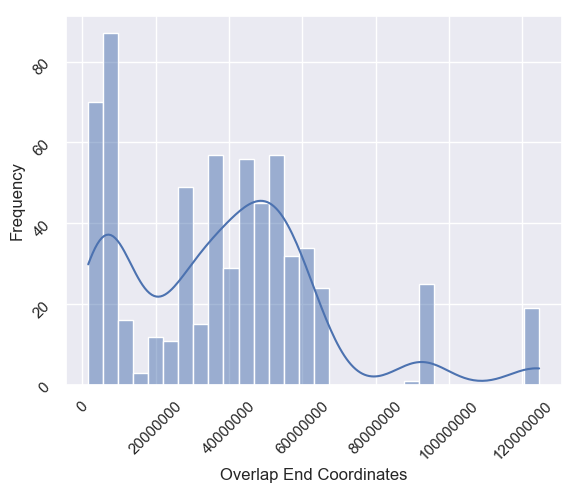

In [9]:
# position of CDR regions
# from matplotlib import pyplot
# fig, (ax1, ax2) = pyplot.subplots(1, 2)

plot = sns.histplot(data=uniques.start, bins=30, kde=True) # plot histogram
plot.ticklabel_format(style='plain', axis='x',useOffset=False)  # get rid of scientific notation values
plot.tick_params(labelrotation=45)  # rotate x ticks
plot.set_xlabel('Overlap End Coordinates')
plot.set_ylabel('Frequency')


     Length
0      5686
1      4429
2     48332
3      5111
4     32249
..      ...
637    2950
638    6862
639   16495
640    2964
641    9190

[642 rows x 1 columns]
     ChrmNum     start       end haplotype
0          2   1901438   1907124     chr21
1          2   2030971   2035400     chr21
2          2   2091821   2140153     chr21
3          2   2190274   2195385     chr21
4          2   3894421   3926670     chr21
..       ...       ...       ...       ...
637        2  55170430  55173380     chr11
638        2  55184935  55191797     chr11
639        2  55221549  55238044     chr11
640        2  55258283  55261247     chr11
641        2  55273077  55282267     chr11

[642 rows x 4 columns]


/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


(0, 40000)

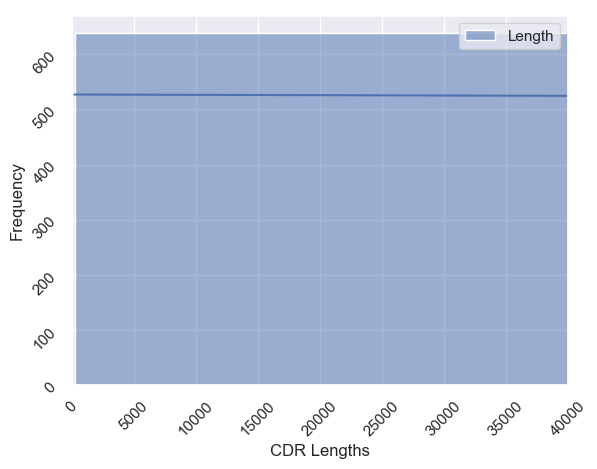

In [10]:
# length of CDR regions
df = pd.DataFrame([(cdr.numChr, cdr.start, cdr.end, cdr.hap) for cdr in cdr_list], 
                    columns=['ChrmNum','start', 'end', 'haplotype'])
lengthDf = pd.DataFrame(df.end-df.start, columns=['Length'])
print(lengthDf)
print(df)

# plot length graph
plot = sns.histplot(data=lengthDf, bins=30, kde=True) # plot histogram
plot.ticklabel_format(style='plain', axis='x',useOffset=False)  # get rid of scientific notation values
plot.tick_params(labelrotation=45)  # rotate x ticks
plot.set_xlabel('CDR Lengths')
plot.set_ylabel('Frequency')
# plot.xlim(0, 30000)
plot.set_xlim(0,40000)

## Exploring each individual chromosome's CDRs

/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


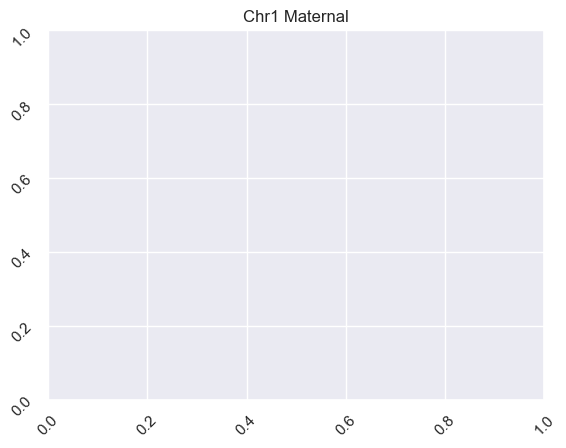

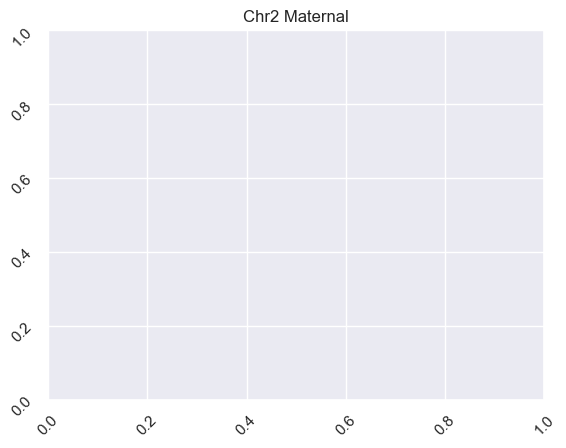

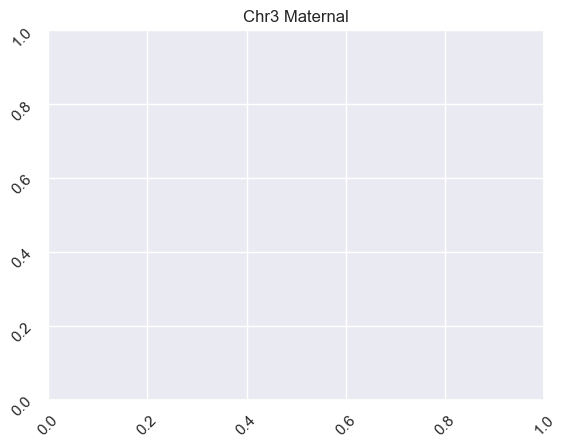

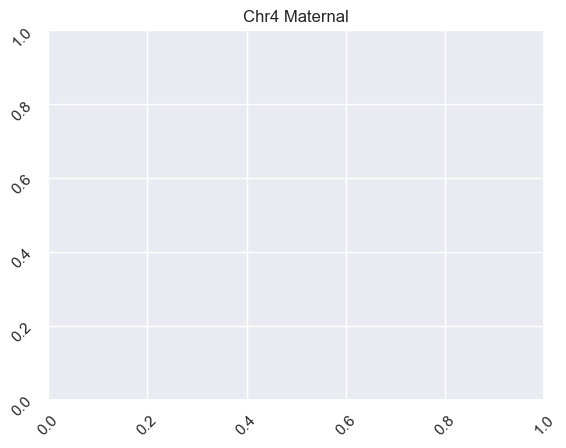

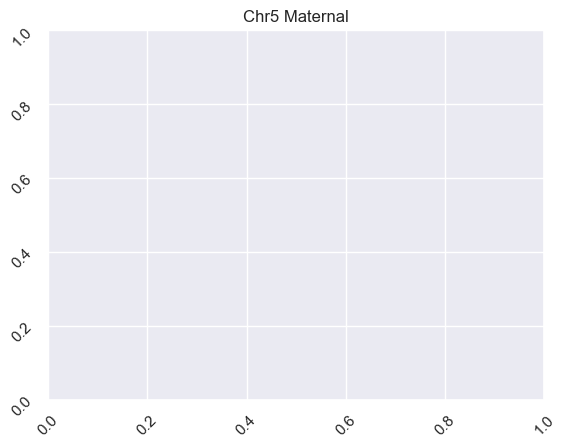

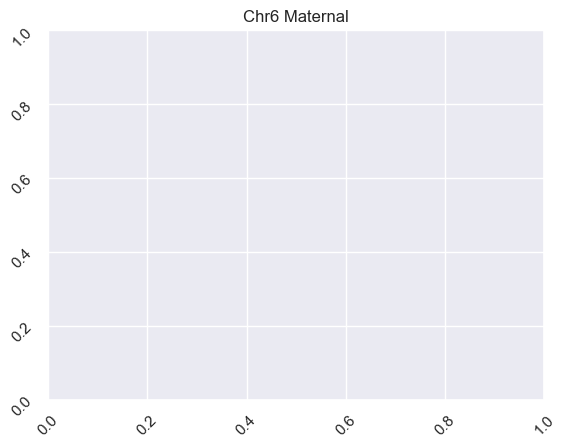

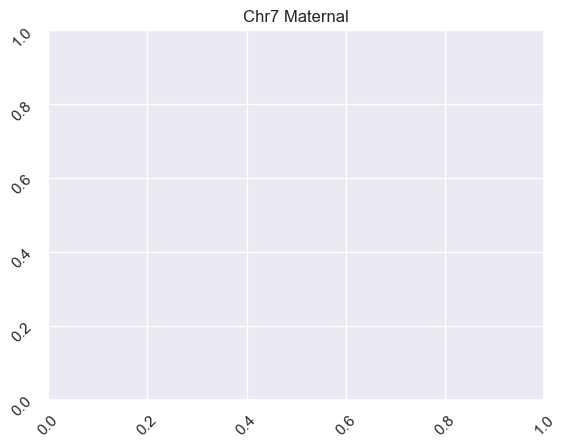

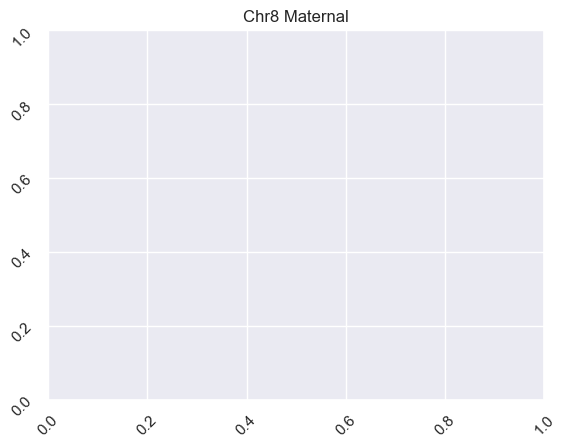

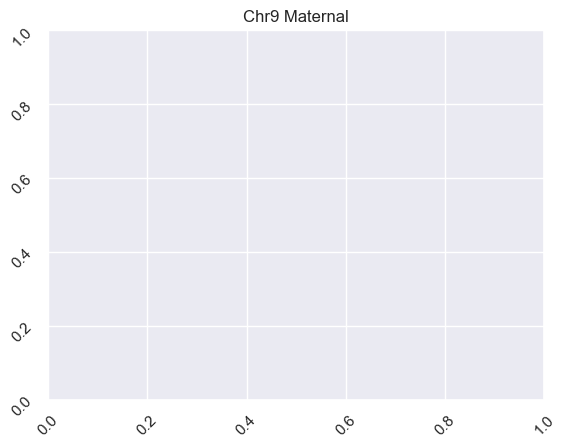

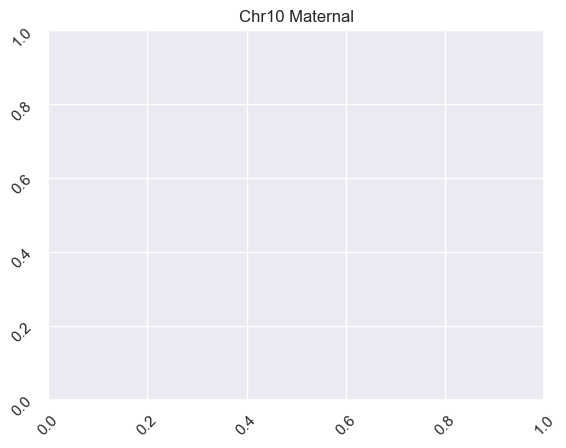

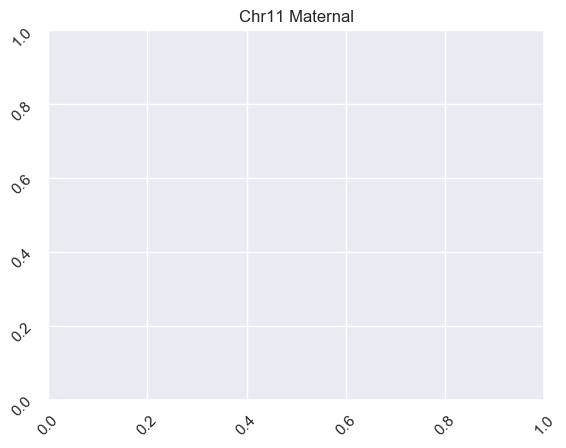

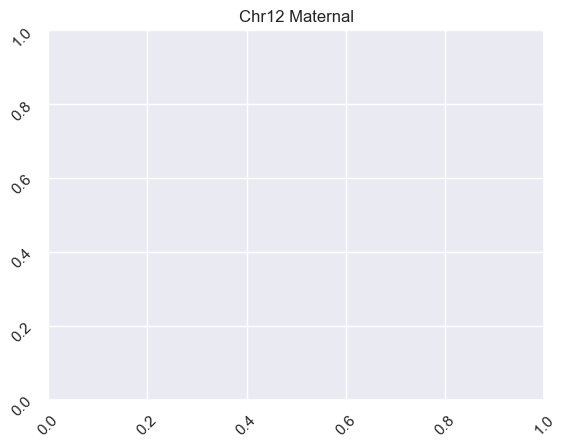

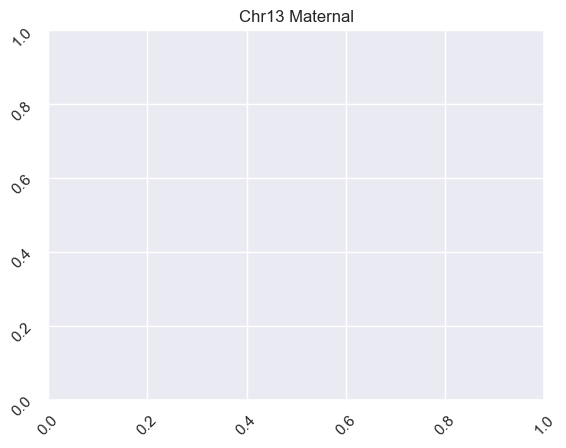

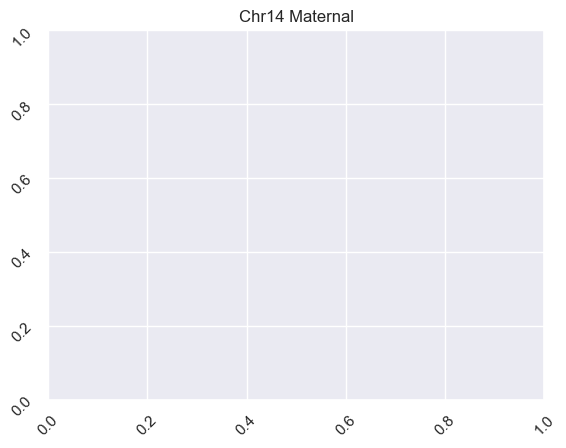

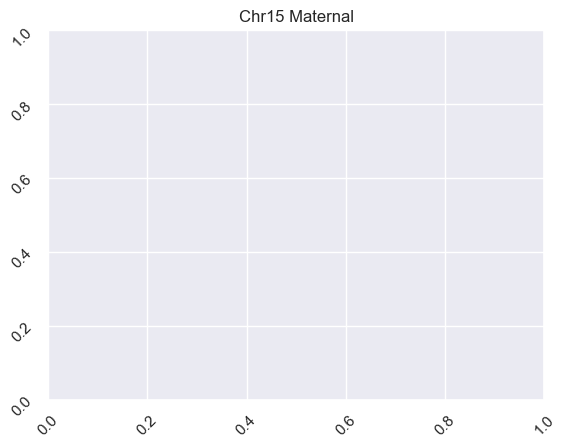

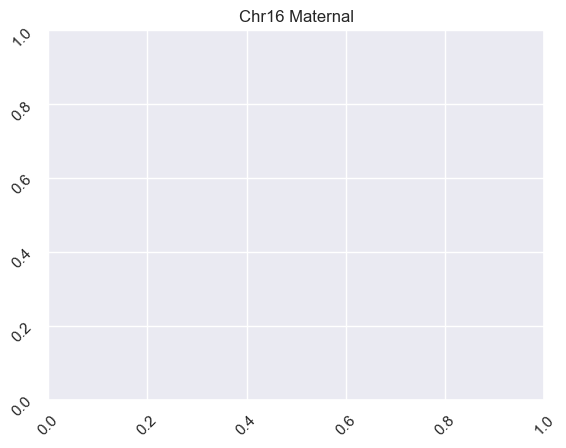

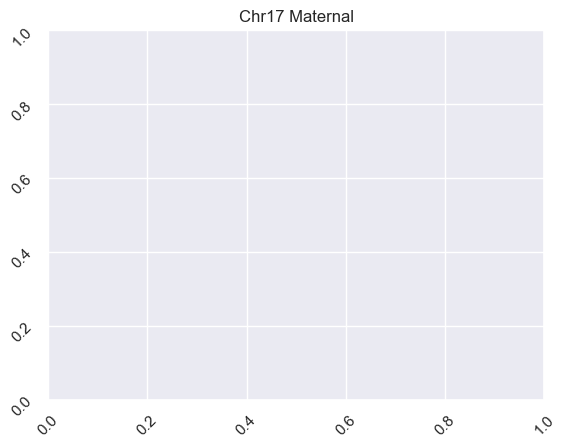

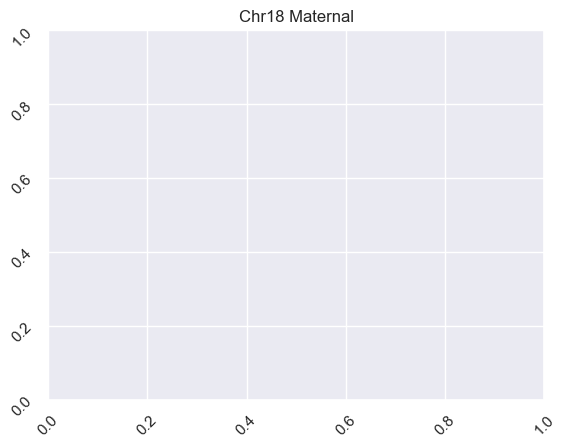

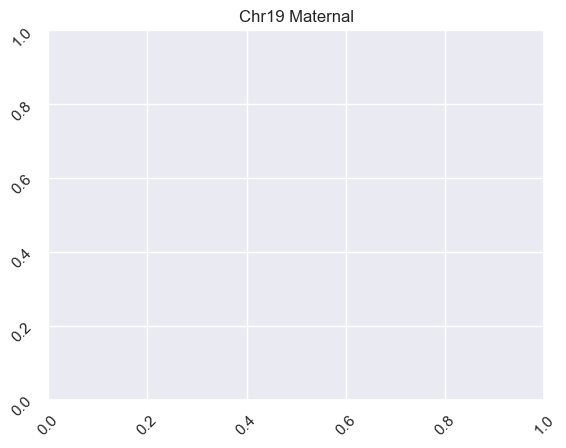

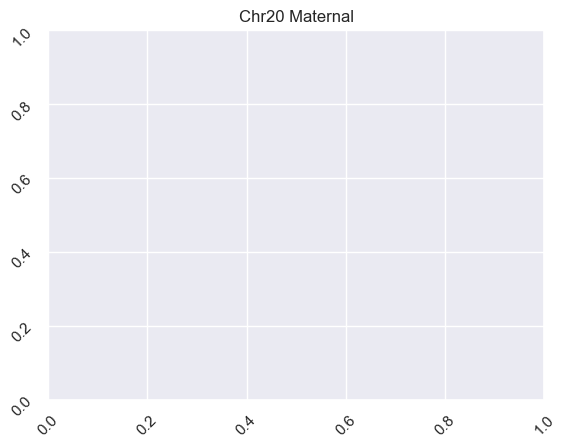

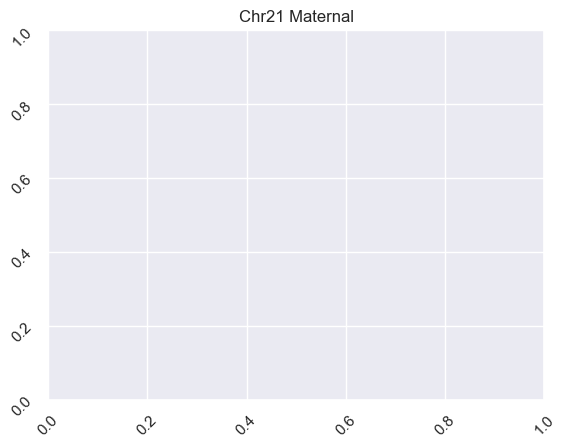

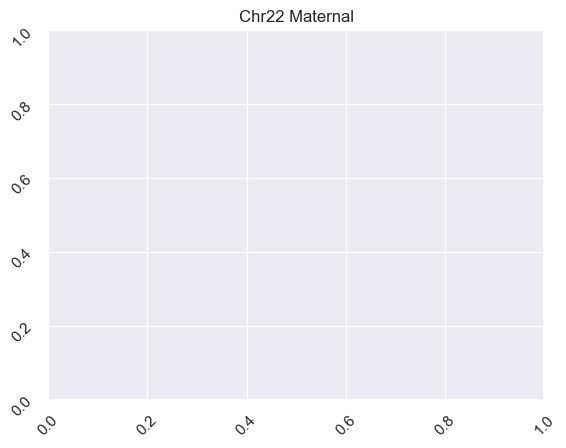

In [11]:
# maternal chromosomes 1-22
chrmNum_hap = df.loc[(df['ChrmNum'] == '6') & (df['haplotype'] == 'maternal')]

# plot = sns.histplot(data=chrmNum_hap.end, bins=30, kde=True) # plot histogram
# plot.ticklabel_format(style='plain', axis='x',useOffset=False)  # get rid of scientific notation values
# plot.tick_params(labelrotation=45)  # rotate x ticks
# plot.set_xlabel('Overlap End Coordinates')
# plot.set_ylabel('Frequency')

# plot = sns.histplot(chrmNum_hap.start, kde=True, color='blue')
# plot.ticklabel_format(style='plain', axis='x',useOffset=False)  # get rid of scientific notation values
# plot.tick_params(labelrotation=45)  # rotate x ticks

# maternal chromosomes 1-22
for chr in range(1,23):
    chrmNum_hap = df.loc[(df['ChrmNum'] == chr) & (df['haplotype'] == 'maternal')]
    pyplot.figure()
    plot = sns.histplot(chrmNum_hap.start, kde=True, color='blue')
    plot.ticklabel_format(style='plain', axis='x',useOffset=False)  # get rid of scientific notation values
    plot.tick_params(labelrotation=45)  # rotate x ticks
    plot.set_title('Chr'+str(chr) + ' Maternal')



/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


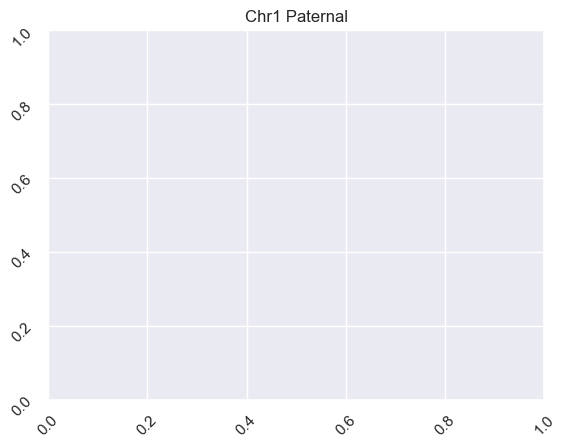

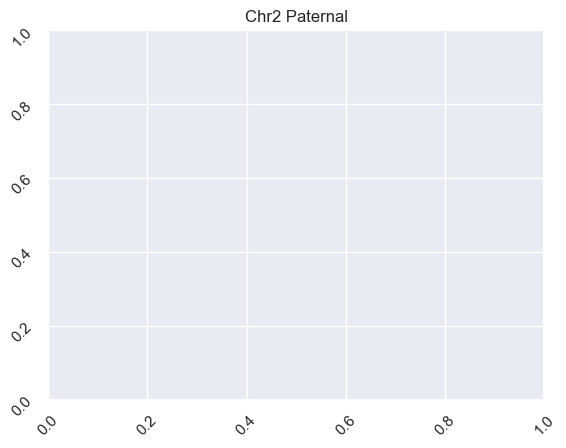

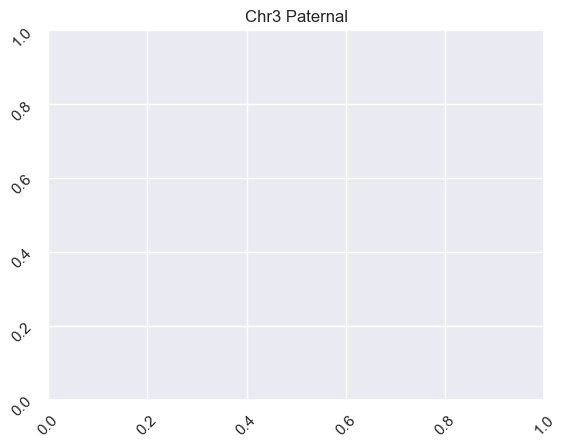

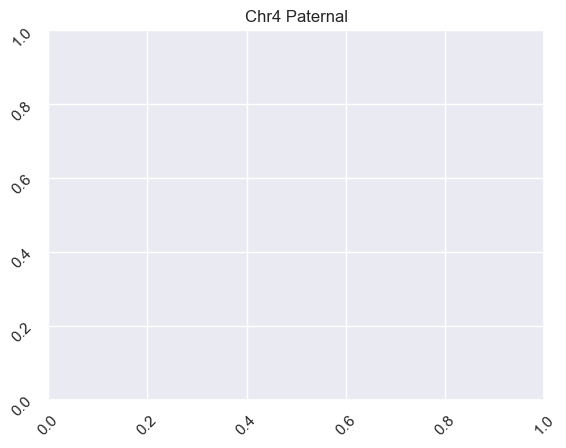

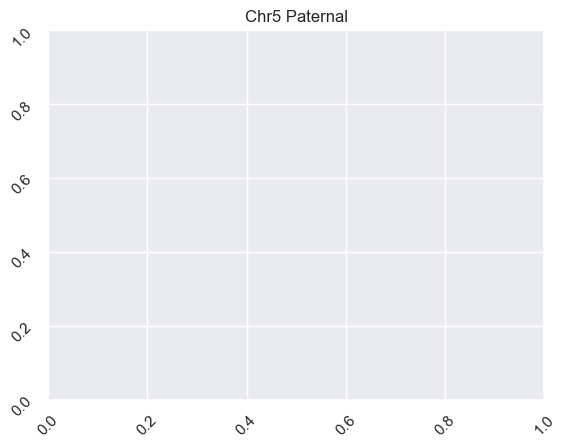

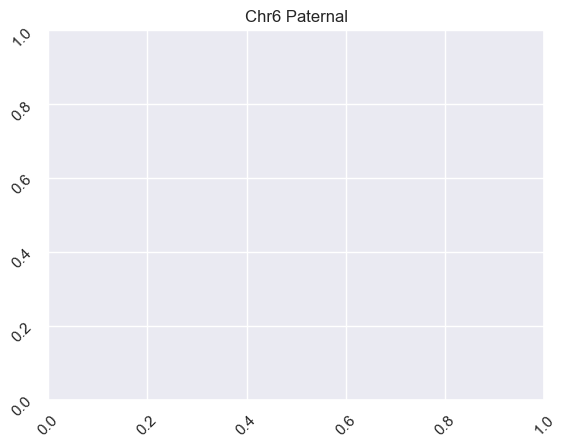

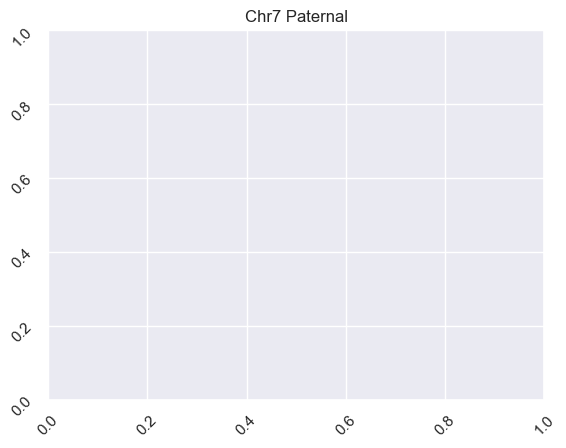

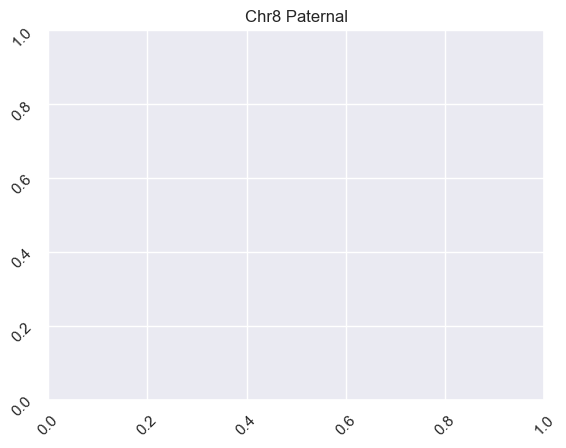

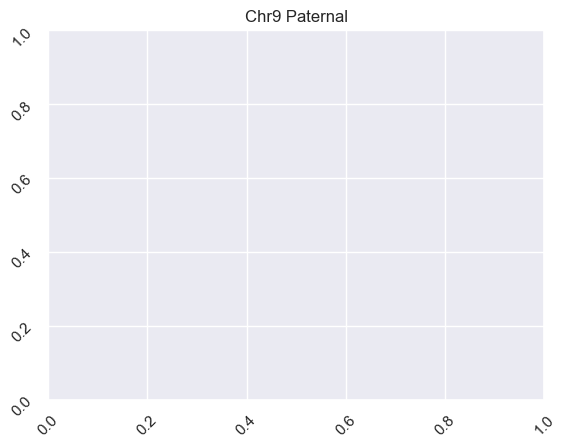

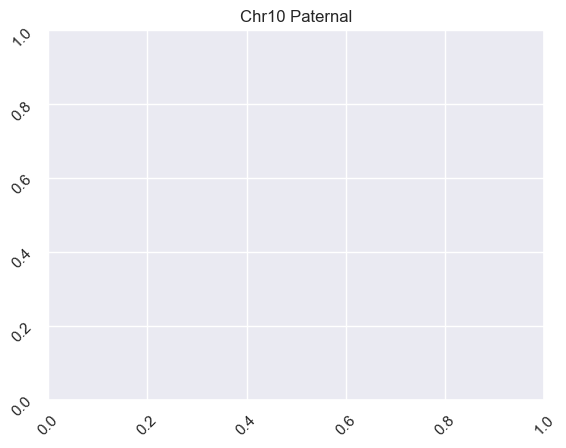

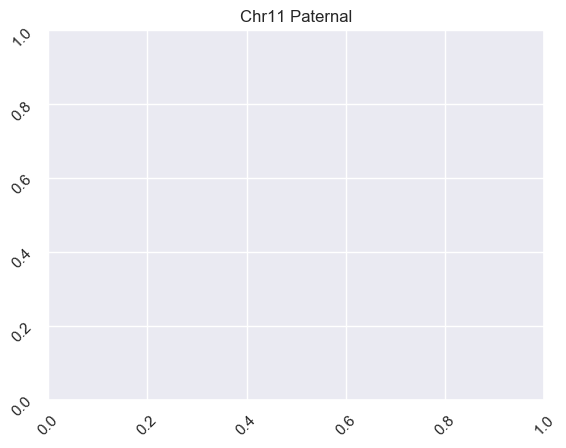

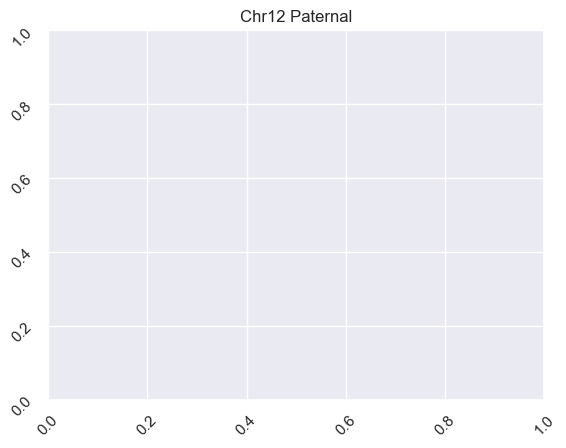

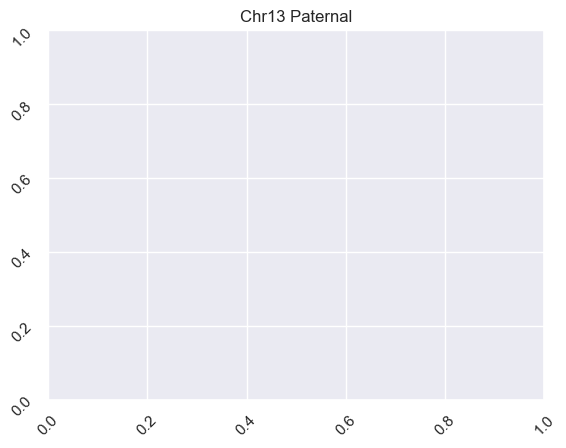

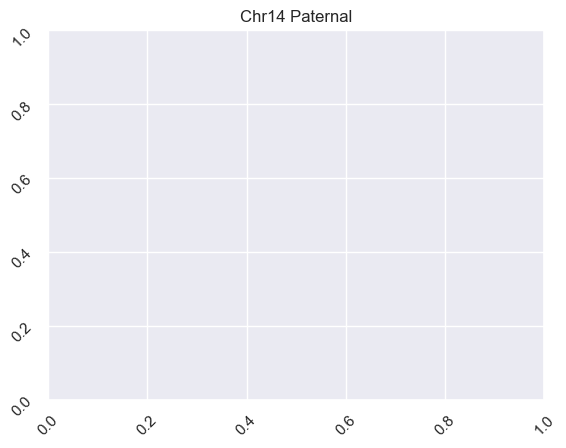

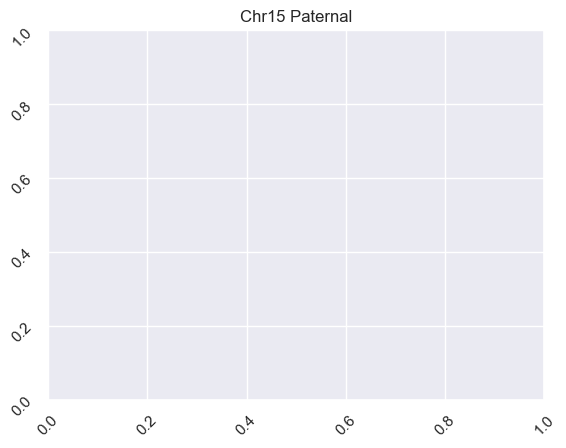

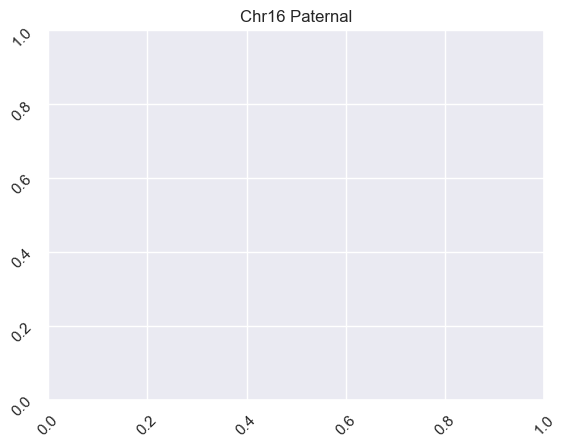

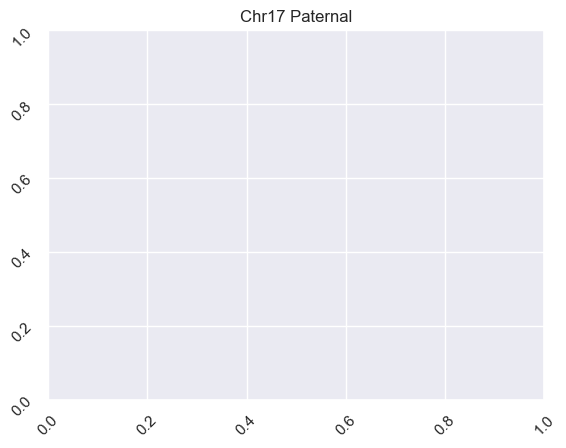

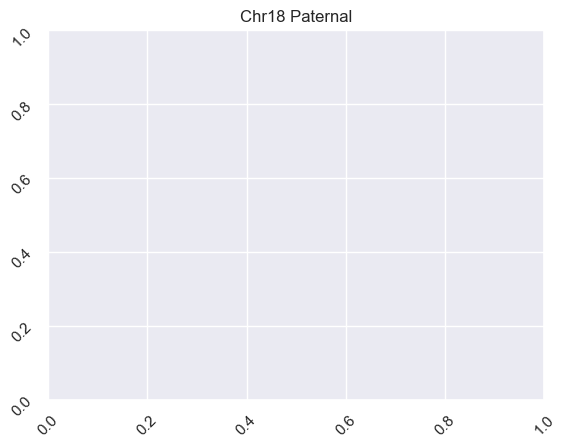

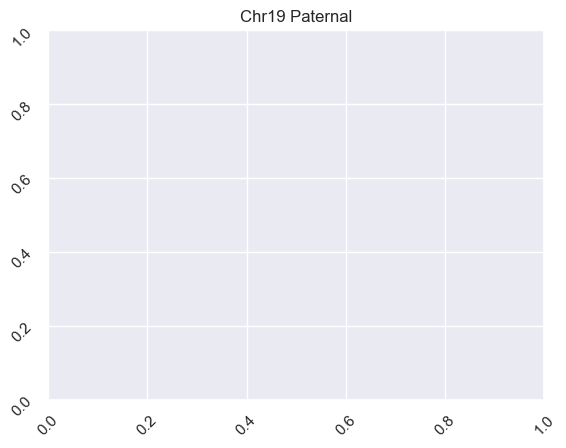

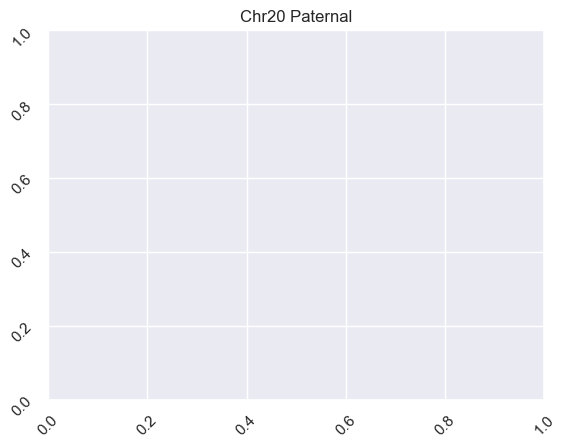

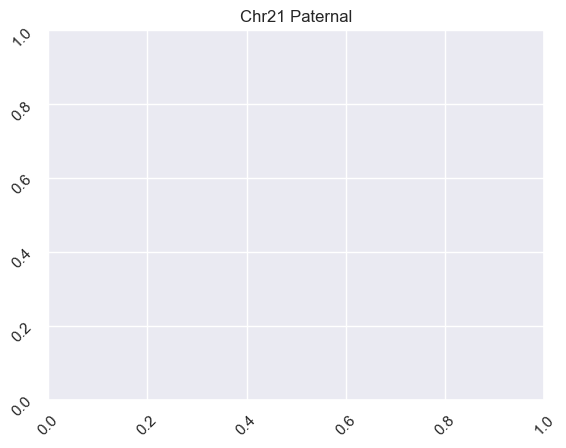

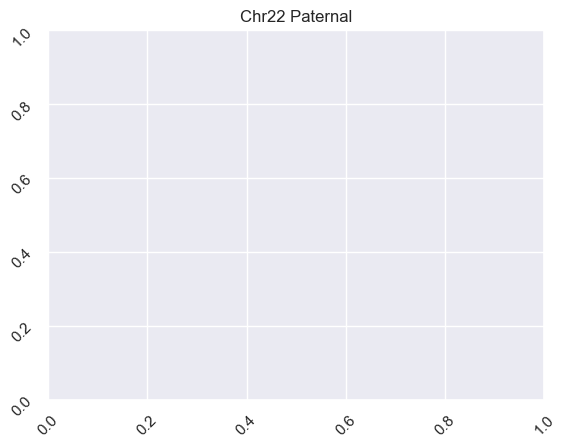

In [12]:
# paternal chromosomes 1-22
for chr in range(1,23):
    chrmNum_hap = df.loc[(df['ChrmNum'] == chr) & (df['haplotype'] == 'paternal')]
    pyplot.figure()
    plot = sns.histplot(chrmNum_hap.start, kde=True, color='blue')
    plot.ticklabel_format(style='plain', axis='x',useOffset=False)  # get rid of scientific notation values
    plot.tick_params(labelrotation=45)  # rotate x ticks
    plot.set_title('Chr'+str(chr) + ' Paternal')

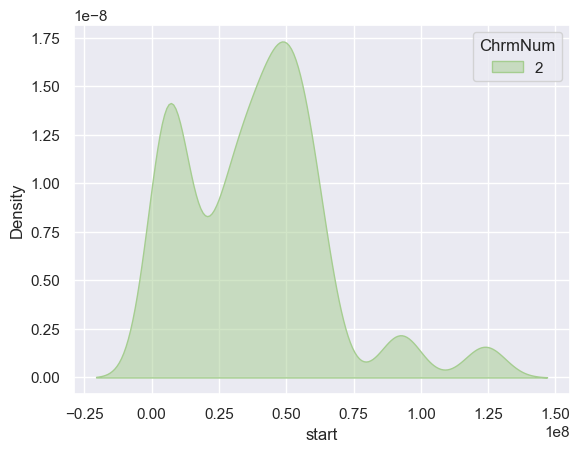

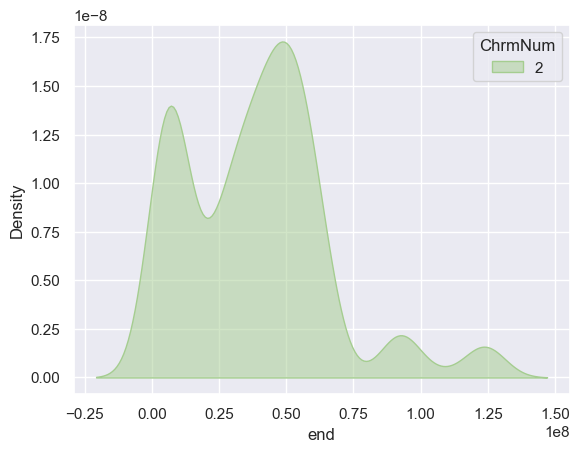

In [13]:
# Density plot
df = pd.DataFrame([(cdr.numChr, cdr.start, cdr.end, cdr.hap) for cdr in cdr_list], 
                    columns=['ChrmNum','start', 'end', 'haplotype'])

from natsort import index_natsorted, order_by_index

df = df.reindex(index=order_by_index(df.index, index_natsorted(df['ChrmNum'], reverse=False)))
# df.sort_values('ChrmNum')
# print(df.to_string())

rangesDF = pd.DataFrame([(cdr.numChr, (int(cdr.start), int(cdr.end)), cdr.hap) for cdr in cdr_list],
                          columns=['ChrmNum','Coordinates', 'haplotype'])

# test different colors
# start coordinates
pyplot.figure()
sns.kdeplot(
   data=df, x="start", hue="ChrmNum",
   fill=True, common_norm=False, palette="crest",
   alpha=0.5, linewidth=1,
)

# end coordinates
pyplot.figure()
sns.kdeplot(
   data=df, x="end", hue="ChrmNum",
   fill=True, common_norm=False, palette="crest",
   alpha=0.5, linewidth=1,
)


      ChrmNum                  ranges haplotype      start        end  length
42480       1  (122587375, 122609375)  maternal  122587375  122609375   22000
42481       1  (122587375, 122609375)  maternal  122587375  122609375   22000
42482       1  (122587375, 122609375)  maternal  122587375  122609375   22000
42483       1  (122587375, 122609375)  maternal  122587375  122609375   22000
42484       1  (122587375, 122609375)  maternal  122587375  122609375   22000
...       ...                     ...       ...        ...        ...     ...
13411       X    (61295698, 61301698)  maternal   61295698   61301698    6000
13412       X    (61295698, 61301698)  maternal   61295698   61301698    6000
13413       X    (61295698, 61301698)  maternal   61295698   61301698    6000
13414       X    (61295698, 61301698)  maternal   61295698   61301698    6000
13415       X    (61295698, 61301698)  maternal   61295698   61301698    6000

[23816 rows x 6 columns]


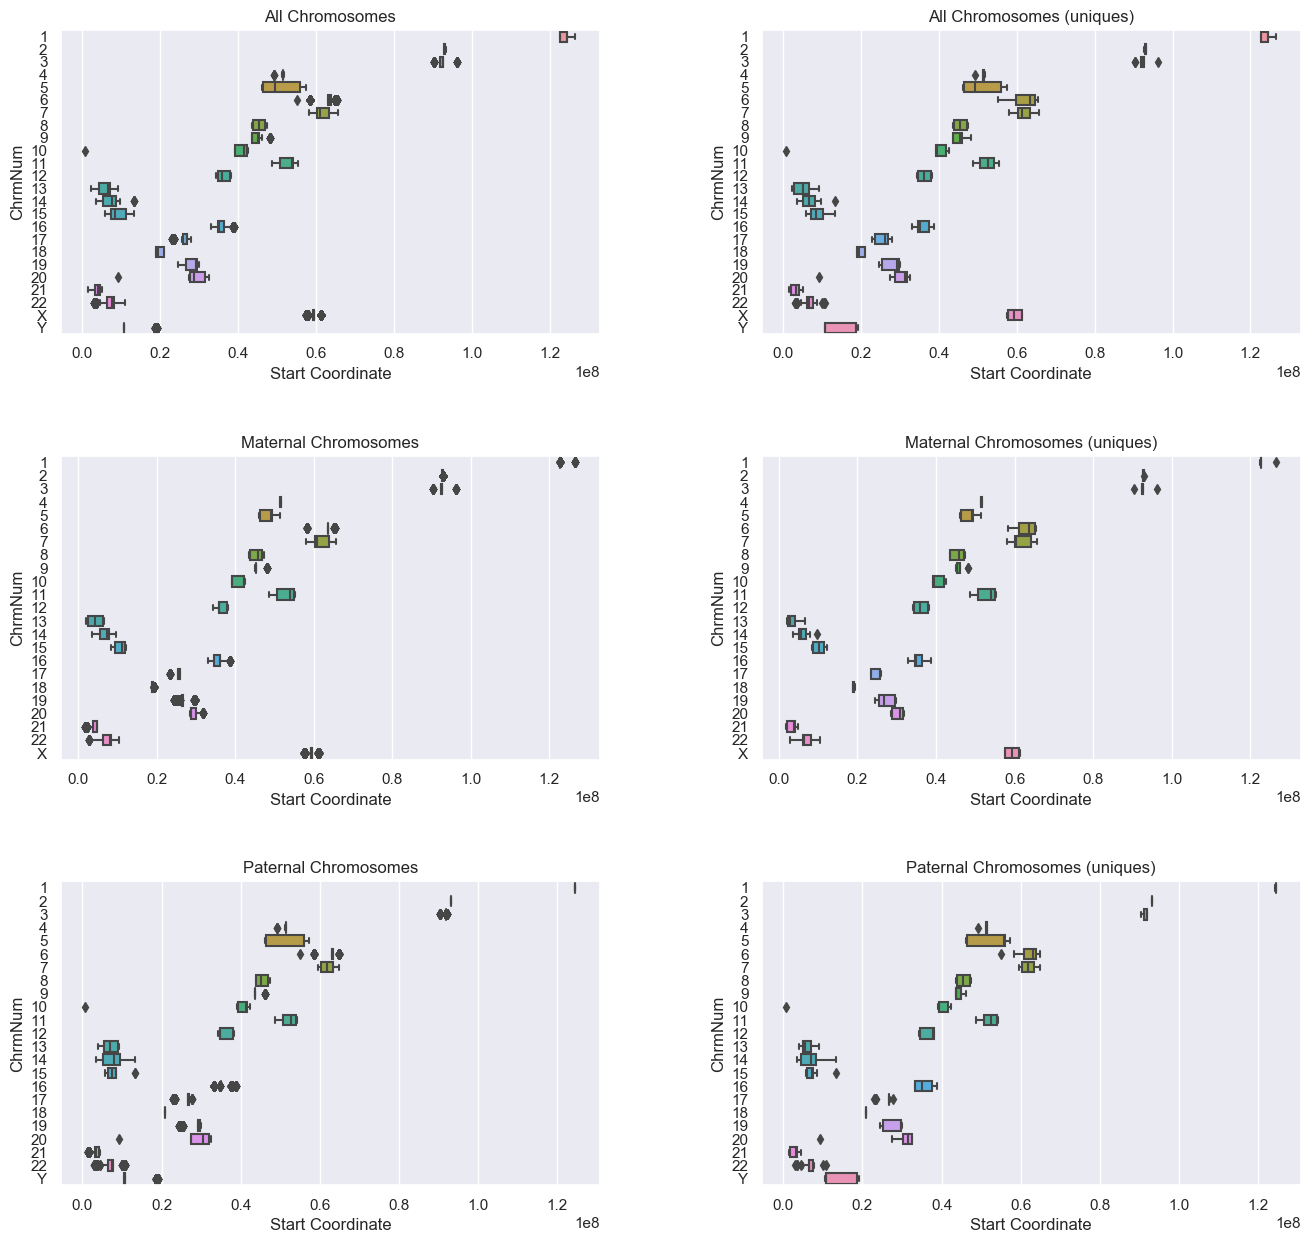

In [32]:
# boxplot of CDR locations
# chrmNum_hap = df.loc[(df['ChrmNum'] == chr) & (df['haplotype'] == 'paternal')]

# df_maternal = df.loc[df['haplotype'] == 'maternal']

fig, axes = pyplot.subplots(3,2, figsize=(16,15))

sns.boxplot(ax=axes[0,0],y=allDF["ChrmNum"], x=allDF["start"]).set_title('All Chromosomes')
axes[0,0].set(xlabel='Start Coordinate')
# axes[0,0].ticklabel_format(style='plain', axis='x',useOffset=False)
# axes[0,0].tick_params(labelrotation=45)

df_maternal = allDF.loc[allDF['haplotype'] == 'maternal']
print(df_maternal)
sns.boxplot(ax=axes[1,0], y=df_maternal["ChrmNum"], x=df_maternal["start"]).set_title('Maternal Chromosomes')
axes[1,0].set(xlabel='Start Coordinate')


df_paternal = allDF.loc[allDF['haplotype'] == 'paternal']
sns.boxplot(ax=axes[2,0],y=df_paternal["ChrmNum"], x=df_paternal["start"]).set_title('Paternal Chromosomes')
axes[2,0].set(xlabel='Start Coordinate')

sns.boxplot(ax=axes[0,1],y=uniques["ChrmNum"], x=uniques["start"]).set_title('All Chromosomes (uniques)')
axes[0,1].set(xlabel='Start Coordinate')

df_maternal = uniques.loc[uniques['haplotype'] == 'maternal']
sns.boxplot(ax=axes[1,1],y=df_maternal["ChrmNum"], x=df_maternal["start"]).set_title('Maternal Chromosomes (uniques)')
axes[1,1].set(xlabel='Start Coordinate')

df_paternal = uniques.loc[uniques['haplotype'] == 'paternal']
sns.boxplot(ax=axes[2,1],y=df_paternal["ChrmNum"], x=df_paternal["start"]).set_title('Paternal Chromosomes (uniques)')
axes[2,1].set(xlabel='Start Coordinate')


# pyplot.figure()
# sns.boxplot(y=allDF["ChrmNum"], x=allDF["start"]).set_title('All Chromosomes')

# df_maternal = allDF.loc[allDF['haplotype'] == 'maternal']
# pyplot.figure()
# sns.boxplot(y=df_maternal["ChrmNum"], x=df_maternal["start"]).set_title('Maternal Chromosomes')

# df_paternal = allDF.loc[allDF['haplotype'] == 'paternal']
# pyplot.figure()
# sns.boxplot(y=df_paternal["ChrmNum"], x=df_paternal["start"]).set_title('Paternal Chromosomes')


# pyplot.figure()
# sns.boxplot(y=uniques["ChrmNum"], x=uniques["start"]).set_title('All Chromosomes (uniques)')

# df_maternal = uniques.loc[uniques['haplotype'] == 'maternal']
# pyplot.figure()
# sns.boxplot(y=df_maternal["ChrmNum"], x=df_maternal["start"]).set_title('Maternal Chromosomes (uniques)')

# df_paternal = uniques.loc[uniques['haplotype'] == 'paternal']
# pyplot.figure()
# sns.boxplot(y=df_paternal["ChrmNum"], x=df_paternal["start"]).set_title('Paternal Chromosomes (uniques)')

pyplot.subplots_adjust(wspace=0.3, hspace=0.4)

    ChrmNum                  ranges haplotype      start        end  length
160       1  (122588553, 122607144)  MATERNAL  122588553  122607144   18591
161       1  (122608264, 122609774)  MATERNAL  122608264  122609774    1510
162       1  (122610340, 122652509)  MATERNAL  122610340  122652509   42169
163       1  (122670602, 122671622)  MATERNAL  122670602  122671622    1020
164       1  (122674913, 122686663)  MATERNAL  122674913  122686663   11750
..      ...                     ...       ...        ...        ...     ...
507       X    (59515374, 59517065)  MATERNAL   59515374   59517065    1691
508       X    (61168247, 61173446)  MATERNAL   61168247   61173446    5199
509       X    (61265884, 61268774)  MATERNAL   61265884   61268774    2890
510       X    (61275238, 61279900)  MATERNAL   61275238   61279900    4662
511       X    (61296286, 61303543)  MATERNAL   61296286   61303543    7257

[288 rows x 6 columns]


[Text(0.5, 0, 'Start Coordinate')]

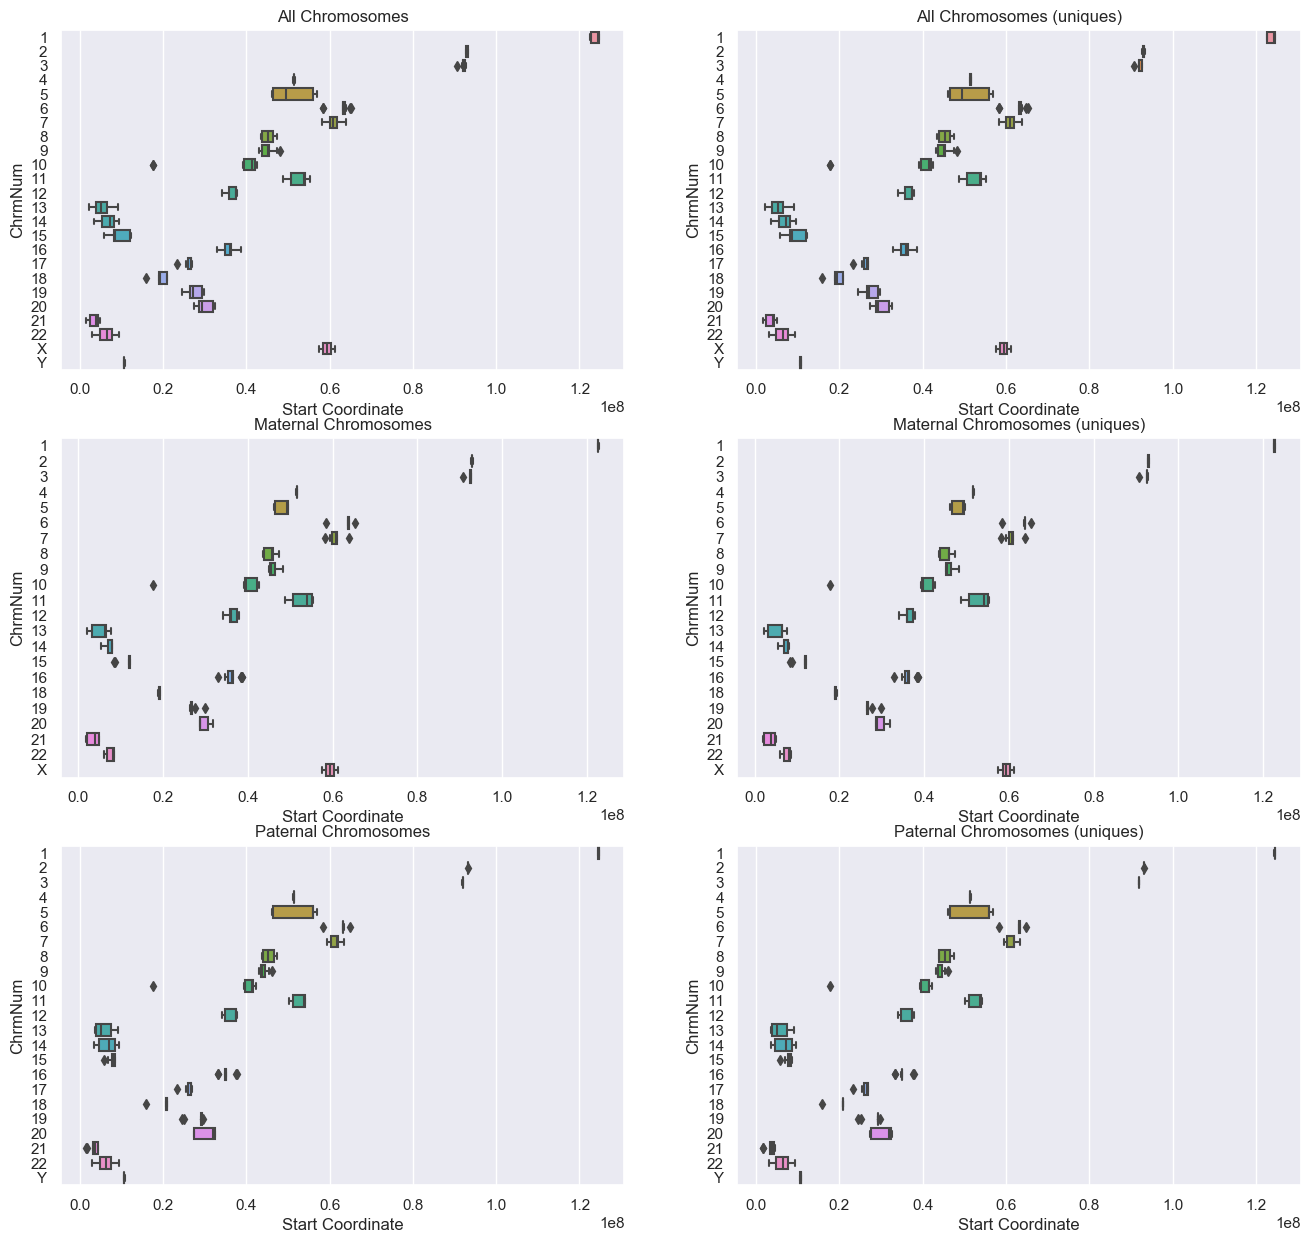

In [38]:
# HMM location boxplots

fig, axes = pyplot.subplots(3,2, figsize=(16,15))

sns.boxplot(ax=axes[0,0],y=allHMM["ChrmNum"], x=allHMM["start"]).set_title('All Chromosomes')
axes[0,0].set(xlabel='Start Coordinate')
# axes[0,0].ticklabel_format(style='plain', axis='x',useOffset=False)
# axes[0,0].tick_params(labelrotation=45)

df_maternal = allHMM.loc[allHMM['haplotype'] == 'MATERNAL']
print(df_maternal)
sns.boxplot(ax=axes[1,0], y=df_maternal["ChrmNum"], x=df_maternal["start"]).set_title('Maternal Chromosomes')
axes[1,0].set(xlabel='Start Coordinate')


df_paternal = allHMM.loc[allHMM['haplotype'] == 'PATERNAL']
sns.boxplot(ax=axes[2,0],y=df_paternal["ChrmNum"], x=df_paternal["start"]).set_title('Paternal Chromosomes')
axes[2,0].set(xlabel='Start Coordinate')

sns.boxplot(ax=axes[0,1],y=uniqueHMM["ChrmNum"], x=uniqueHMM["start"]).set_title('All Chromosomes (uniques)')
axes[0,1].set(xlabel='Start Coordinate')

df_maternal = uniqueHMM.loc[uniqueHMM['haplotype'] == 'MATERNAL']
sns.boxplot(ax=axes[1,1],y=df_maternal["ChrmNum"], x=df_maternal["start"]).set_title('Maternal Chromosomes (uniques)')
axes[1,1].set(xlabel='Start Coordinate')

df_paternal = uniqueHMM.loc[uniqueHMM['haplotype'] == 'PATERNAL']
sns.boxplot(ax=axes[2,1],y=df_paternal["ChrmNum"], x=df_paternal["start"]).set_title('Paternal Chromosomes (uniques)')
axes[2,1].set(xlabel='Start Coordinate')

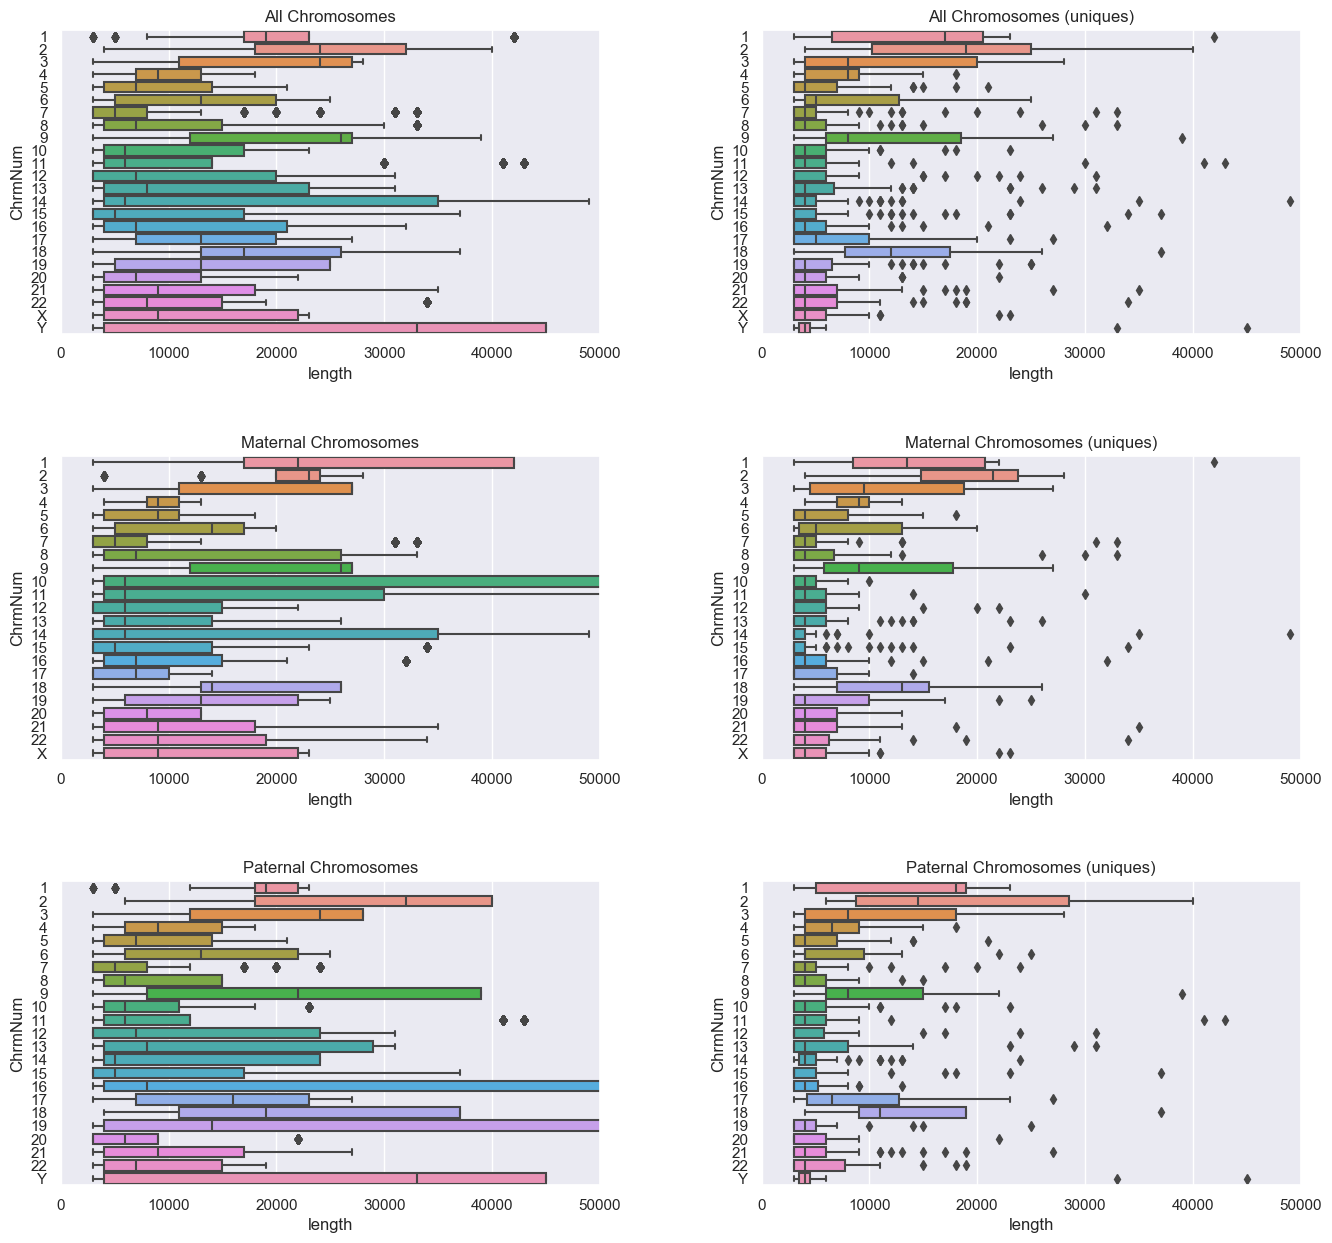

In [33]:
# boxplot of CDR lengths
fig, axes = pyplot.subplots(3,2, figsize=(16,15))

sns.boxplot(ax=axes[0,0],y=allDF["ChrmNum"], x=allDF["length"]).set_title('All Chromosomes')
axes[0,0].set_xlim(0, 50000)
# axes[0,0].set_xticks(np.arange(0, 60000, 5000))
# axes[0,0].tick_params(labelrotation=45)

df_maternal = allDF.loc[allDF['haplotype'] == 'maternal']
sns.boxplot(ax=axes[1,0], y=df_maternal["ChrmNum"], x=df_maternal["length"]).set_title('Maternal Chromosomes')
axes[1,0].set_xlim(0, 50000)
# axes[1,0].set_xticks(np.arange(0, 75000, 5000))
# axes[1,0].tick_params(labelrotation=45)

df_paternal = allDF.loc[allDF['haplotype'] == 'paternal']
sns.boxplot(ax=axes[2,0],y=df_paternal["ChrmNum"], x=df_paternal["length"]).set_title('Paternal Chromosomes')
axes[2,0].set_xlim(0, 50000)
# axes[2,0].set_xticks(np.arange(0, 75000, 5000))
# axes[2,0].tick_params(labelrotation=45)

sns.boxplot(ax=axes[0,1],y=uniques["ChrmNum"], x=uniques["length"]).set_title('All Chromosomes (uniques)')
axes[0,1].set_xlim(0, 50000)
# axes[0,1].set_xticks(np.arange(0, 35000, 5000))
# axes[0,1].tick_params(labelrotation=45)

df_maternal = uniques.loc[uniques['haplotype'] == 'maternal']
sns.boxplot(ax=axes[1,1],y=df_maternal["ChrmNum"], x=df_maternal["length"]).set_title('Maternal Chromosomes (uniques)')
axes[1,1].set_xlim(0, 50000)
# axes[1,1].set_xticks(np.arange(0, 35000, 5000))
# axes[1,1].tick_params(labelrotation=45)

df_paternal = uniques.loc[uniques['haplotype'] == 'paternal']
sns.boxplot(ax=axes[2,1],y=df_paternal["ChrmNum"], x=df_paternal["length"]).set_title('Paternal Chromosomes (uniques)')
axes[2,1].set_xlim(0, 50000)
# axes[2,1].set_xticks(np.arange(0, 35000, 5000))
# axes[2,1].tick_params(labelrotation=45)
# axes[2,1].set_xticklabels(np.arange(0, 35000, 2500),rotation=45)

pyplot.subplots_adjust(wspace=0.3, hspace=0.4)

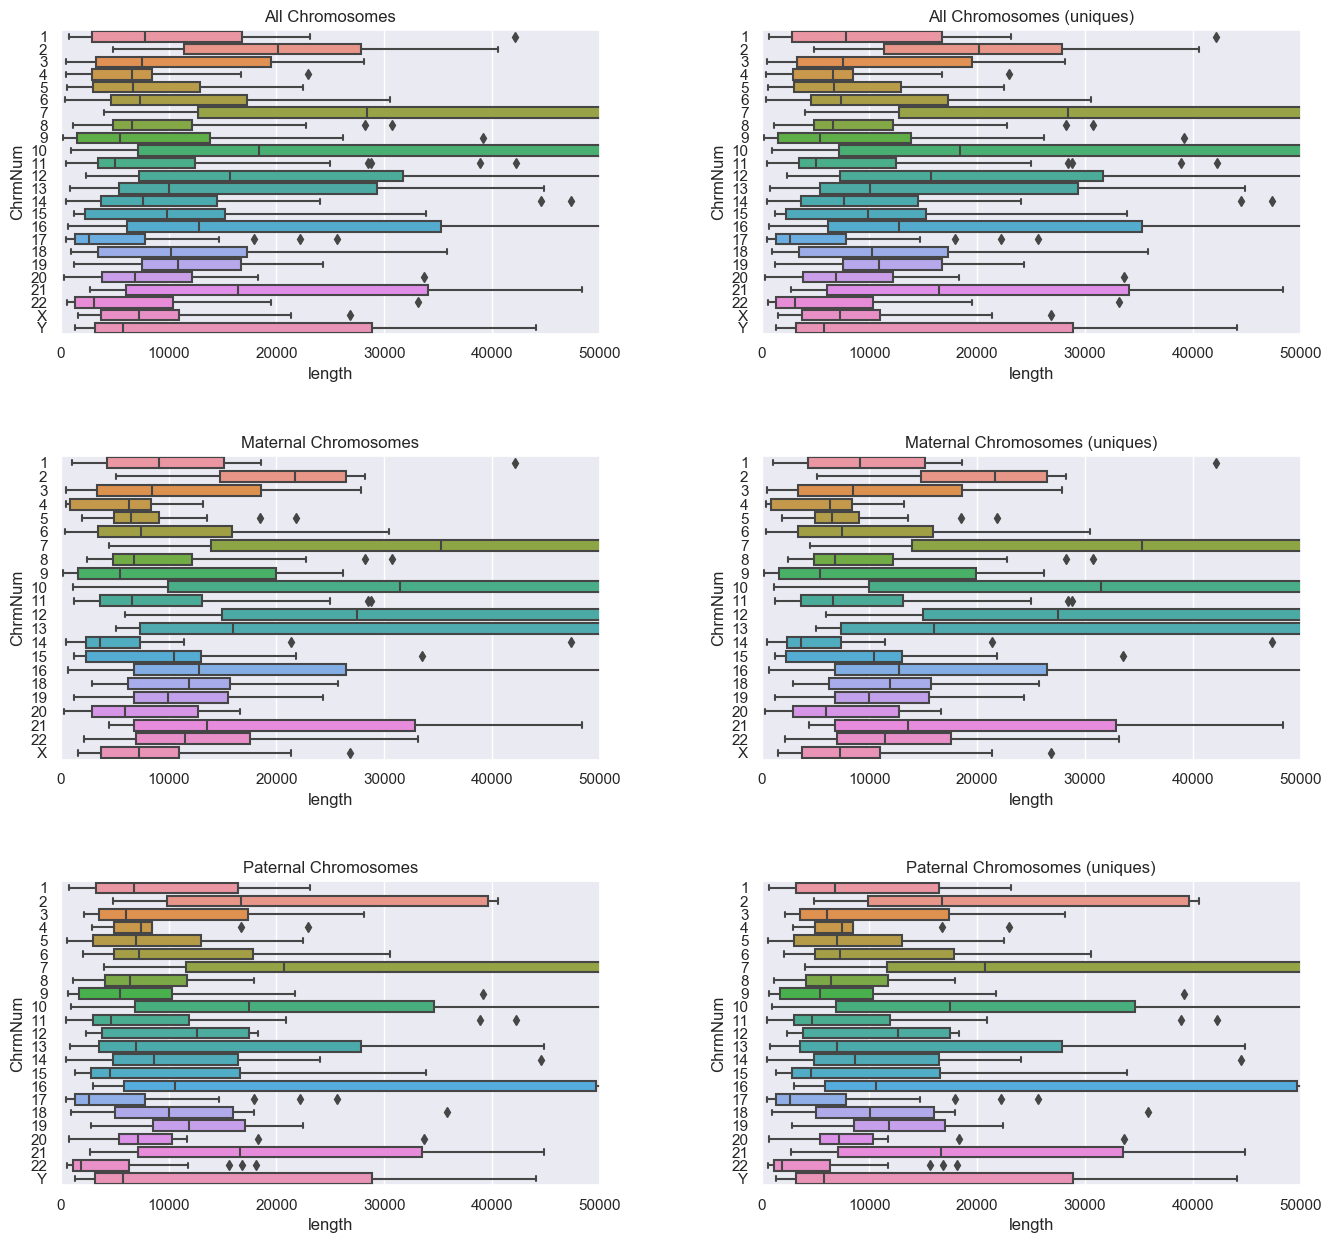

In [39]:
# boxplot of HMM CDR lengths
fig, axes = pyplot.subplots(3,2, figsize=(16,15))

sns.boxplot(ax=axes[0,0],y=allHMM["ChrmNum"], x=allHMM["length"]).set_title('All Chromosomes')
axes[0,0].set_xlim(0, 50000)
# axes[0,0].set_xticks(np.arange(0, 60000, 5000))
# axes[0,0].tick_params(labelrotation=45)

df_maternal = allHMM.loc[allHMM['haplotype'] == 'MATERNAL']
sns.boxplot(ax=axes[1,0], y=df_maternal["ChrmNum"], x=df_maternal["length"]).set_title('Maternal Chromosomes')
axes[1,0].set_xlim(0, 50000)
# axes[1,0].set_xticks(np.arange(0, 75000, 5000))
# axes[1,0].tick_params(labelrotation=45)

df_paternal = allHMM.loc[allHMM['haplotype'] == 'PATERNAL']
sns.boxplot(ax=axes[2,0],y=df_paternal["ChrmNum"], x=df_paternal["length"]).set_title('Paternal Chromosomes')
axes[2,0].set_xlim(0, 50000)
# axes[2,0].set_xticks(np.arange(0, 75000, 5000))
# axes[2,0].tick_params(labelrotation=45)

sns.boxplot(ax=axes[0,1],y=uniqueHMM["ChrmNum"], x=uniqueHMM["length"]).set_title('All Chromosomes (uniques)')
axes[0,1].set_xlim(0, 50000)
# axes[0,1].set_xticks(np.arange(0, 35000, 5000))
# axes[0,1].tick_params(labelrotation=45)

df_maternal = uniqueHMM.loc[uniqueHMM['haplotype'] == 'MATERNAL']
sns.boxplot(ax=axes[1,1],y=df_maternal["ChrmNum"], x=df_maternal["length"]).set_title('Maternal Chromosomes (uniques)')
axes[1,1].set_xlim(0, 50000)
# axes[1,1].set_xticks(np.arange(0, 35000, 5000))
# axes[1,1].tick_params(labelrotation=45)

df_paternal = uniqueHMM.loc[uniqueHMM['haplotype'] == 'PATERNAL']
sns.boxplot(ax=axes[2,1],y=df_paternal["ChrmNum"], x=df_paternal["length"]).set_title('Paternal Chromosomes (uniques)')
axes[2,1].set_xlim(0, 50000)
# axes[2,1].set_xticks(np.arange(0, 35000, 5000))
# axes[2,1].tick_params(labelrotation=45)
# axes[2,1].set_xticklabels(np.arange(0, 35000, 2500),rotation=45)

pyplot.subplots_adjust(wspace=0.3, hspace=0.4)